In [1]:
import torch
import platform

import torchvision.transforms as transforms
import matplotlib.pylab as plt
import matplotlib.image as mpimg
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import numpy as np

from PIL import Image
from torchvision.utils import save_image

Verify torch device availability for MacOS. It must be at least 12.3 and must have MPS activated.

In [2]:
if platform.system() == 'Darwin':
    print(f"Torch MPS Available: {torch.backends.mps.is_available()}")
    print(f"Torch MPS Built: {torch.backends.mps.is_built()}")
else:
    print(torch.cuda.is_available())
    print(f"CUDA Devides: {torch.cuda.device_count()}")
    print(f"Current CUDA Index: {torch.cuda.current_device()}")

Torch MPS Available: True
Torch MPS Built: True


VGG19 will be used for the style tranfer model using a convolutional approach.

In [3]:
#Loadung the model vgg19 that will serve as the base model
model=models.vgg19(pretrained=True).features

#Assigning the GPU to the variable device based on the platform
if platform.system() == 'Darwin':
    device=torch.device("mps")
else:
    device=torch.device( "cuda" if (torch.cude.is_available()) else 'cpu')

/Users/alonzomachiraju/anaconda3/envs/mlp/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/alonzomachiraju/anaconda3/envs/mlp/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Define our source styles and predefined content for this test notebook.

In [4]:
content_urls = dict(
    oxford = "./test_img/oxford.jpg",
    eiffel_tower = "./test_img/eiffel_tower.jpg",
    elephant = "./test_img/elephant.jpg",
    hotdog = "./test_img/hotdog.jpg",
    office = "./test_img/office.jpg",
    room = "./test_img/room.jpg",
    traffic = "./test_img/traffic.jpg",
    zebra = "./test_img/zebra.jpg",
    bicycle = "./test_img/imagenet_images/bicycle.jpg",
    dog = "./test_img/imagenet_images/dog.jpg",
    Lion = "./test_img/imagenet_images/Lion.jpg",
    ship = "./test_img/imagenet_images/ship.jpg",
    tiger = "./test_img/imagenet_images/tiger.jpg",
    yacht = "./test_img/imagenet_images/yacht.jpg",
)
style_urls = dict(
    bouguereau_abduction_psyche = "./transfer_source/bouguereau_abduction_psyche.jpeg",
    bouguereau_bacchante = "./transfer_source/bouguereau_bacchante.jpeg",
    bouguereau_dawn = "./transfer_source/bouguereau_dawn.jpeg",
    bouguereau_gabrielle_cot = "./transfer_source/bouguereau_gabrielle_cot.jpeg",
    bouguereau_nymphs_and_satyr = "./transfer_source/bouguereau_nymphs_and_satyr.jpeg",
    bouguereau_venus_anodyne = "./transfer_source/bouguereau_venus_anodyne.jpeg",
    bouguereau_evening_mood = "./transfer_source/bouguereau_evening_mood.jpeg",
    galaxy_of_musicians = "./transfer_source/galaxy_of_musicians.jpeg",
    gerome_femme_circassienne_voilee = "./transfer_source/gerome_femme_circassienne_voilee.jpeg",
    gerome_gladiator_death = "./transfer_source/gerome_gladiator_death.jpeg",
    gerome_phryne = "./transfer_source/gerome_phryne.jpeg",
    monalisa = "./transfer_source/monalisa.jpeg",
    raphael_young_man = "./transfer_source/raphael_young_man.jpeg",
    starry_night = "./transfer_source/starry_night.jpg",
    feathers = "./transfer_source/feathers.jpg",
    candy = "./transfer_source/candy.jpg",
    the_scream = "./transfer_source/the_scream.jpg",
    mosaic = "./transfer_source/mosaic.jpg",
    la_muse = "./transfer_source/la_muse.jpg",
)

content_name = 'oxford'  # @param from content_urls
style_name = 'the_scream'  # @param from style_urls

Helper functions for displaying images.

In [5]:
def show_images(images, titles=('',), dim = 1024):
    n = len(images)
    for i in range(n):
        img = mpimg.imread(images[i])
        plt.imshow(img, aspect='equal')
        plt.title(titles[i] if len(titles) > i else '')
        plt.show()

**Image Preprocessing**

To make an image compatible with the model, the image has to be preprocessed. Using the torch.transforms() we will perform some of the basic preprocessing that will include the following steps:

- Resize: resize all the image to 512 x 512
- ToTensor: to convert the image into a tensor

You can also Normalize the tensor with mean (0.485, 0.456, 0.406) and standard deviation of (0.229, 0.224, 0.225) for the pretrained vgg19 model. But don’t forget to convert it back to its original scale. So, define a function that loads the image using the PIL library and preprocess it. Add an extra dimension at 0th index, using unsqueeze() for batch size and then load it to the device and return it.
Now, use the image_loader function to load the style and the content image from the local disk. It’s a general practice to use the content image clone as the input base image or the generated image. Since the gradient descent will alter the generated image's pixel values, we will pass the parameter true for require_grads().

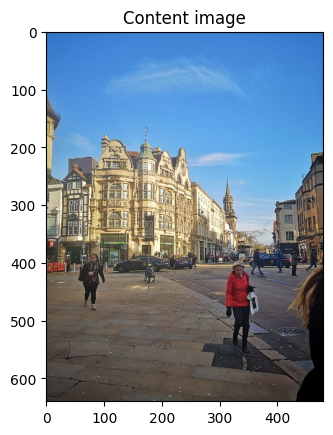

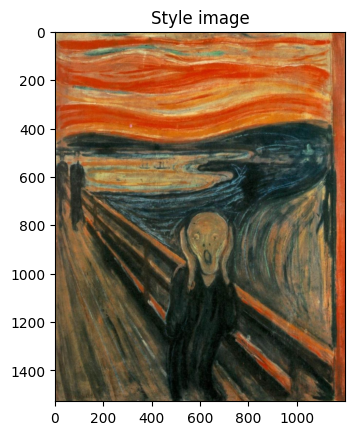

In [6]:
#defing a function that will load the image and perform the required preprocessing and put it on the GPU
def image_loader(path):
    image=Image.open(path)
    #defining the image transformation steps to be performed before feeding them to the model
    loader=transforms.Compose([transforms.Resize((512,512)), transforms.ToTensor()])
    #The preprocessing steps involves resizing the image and then converting it to a tensor
    image=loader(image).unsqueeze(0)
    return image.to(device,torch.float)

#Loading the original and the style image
content_image=image_loader(content_urls[content_name])
style_image=image_loader(style_urls[style_name])

show_images([content_urls[content_name], style_urls[style_name]], titles=['Content image', 'Style image'])

#Creating the generated image from the original image
generated_image=content_image.clone().requires_grad_(True)

**Get Feature Representations**

Let’s define a class that will provide the feature representations of the intermediate layers. Intermediate layers are used because these layers serve as a complex feature extractor. Hence these can describe the style and content of the input image. In this class, we will initialize a model by eliminating the unused layers( layers beyond conv5_1) of the vgg19 model and extract the activations or the feature representations of the ‘conv1_1’, ‘conv2_1’, ‘conv3_1’, ‘conv4_1’ and ‘conv5_1’ layers (index values [0, 5, 10, 19, 28]). Store these activations of 5 convolutional layers in an array and return the array.

In [7]:
#Defining a class that for the model
class VGG(nn.Module):
    def __init__(self):
        super(VGG,self).__init__()
        self.req_features= ['0','5','10','19','28'] 
        #Since we need only the 5 layers in the model so we will be dropping all the rest layers from the features of the model
        self.model=models.vgg19(pretrained=True).features[:29] #model will contain the first 29 layers
    
   
    #x holds the input tensor(image) that will be feeded to each layer
    def forward(self,x):
        #initialize an array that wil hold the activations from the chosen layers
        features=[]
        #Iterate over all the layers of the mode
        for layer_num,layer in enumerate(self.model):
            #activation of the layer will stored in x
            x=layer(x)
            #appending the activation of the selected layers and return the feature array
            if (str(layer_num) in self.req_features):
                features.append(x)
                
        return features

In [8]:
def calc_content_loss(gen_feat,orig_feat):
    #calculating the content loss of each layer by calculating the MSE between the content and generated features and adding it to content loss
    content_l=torch.mean((gen_feat-orig_feat)**2)
    return content_l

In [9]:
def calc_style_loss(gen,style):
    #Calculating the gram matrix for the style and the generated image
    batch_size,channel,height,width=gen.shape

    G=torch.mm(gen.view(channel,height*width),gen.view(channel,height*width).t())
    A=torch.mm(style.view(channel,height*width),style.view(channel,height*width).t())
        
    #Calcultating the style loss of each layer by calculating the MSE between the gram matrix of the style image and the generated image and adding it to style loss
    style_l=torch.mean((G-A)**2)
    return style_l

In [10]:
def calculate_loss(gen_features, orig_feautes, style_featues):
    style_loss=content_loss=0
    for gen,cont,style in zip(gen_features,orig_feautes,style_featues):
        #extracting the dimensions from the generated image
        content_loss+=calc_content_loss(gen,cont)
        style_loss+=calc_style_loss(gen,style)
    
    #calculating the total loss of e th epoch
    total_loss=alpha*content_loss + beta*style_loss 
    return total_loss

**Training**

Initialize the variables that we will need to train our model. So, before moving on to train, we need to set the hyperparameters.

In [11]:
#Load the model to the GPU
model=VGG().to(device).eval() 

#initialize the paramerters required for fitting the model
epoch=250
lr=0.004
alpha=8
beta=70

#using adam optimizer and it will update the generated image not the model parameter 
optimizer=optim.Adam([generated_image],lr=lr)

Here, create an object for the class VGG. Initializing the object will call the constructor and it will return a model with the first 29 layers and load it to the device. Epoch is 1000, the learning rate is 0.01, alpha(weighting coefficient of content loss) is 1 and beta(weighting coefficient of style loss) is 0.01.

Adam is used as an optimizer. The pixel data of the generated image will be optimized to pass the generated image as the optimizer parameter.
Use a for loop to iterate over the number of epochs. Extract the feature representation of the intermediate layers of the content, style and the generated image using the model. On passing an image to the model, it will return an array of length 5. Each element corresponds to the feature representation of each intermediate layer.

Calculate the total loss by using the above-defined functions. Set the gradients to zero with optimizer.zero_grads(), backpropagate the total loss with total_loss.backward() and then update the pixel values of the generated image using optimizer.step(). We will save the generated image after every 100 epochs and print the total loss.

In [12]:
#iterating for number of training epochs
for e in range (epoch):
    print(f'epoch {e}')
    #extracting the features of generated, content and the original required for calculating the loss
    gen_features=model(generated_image)
    orig_feautes=model(content_image)
    style_featues=model(style_image)
    
    #iterating over the activation of each layer and calculate the loss and add it to the content and the style loss
    total_loss=calculate_loss(gen_features, orig_feautes, style_featues)
    #optimize the pixel values of the generated image and backpropagate the loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    #print the image and save it after each 100 epoch
    if(e/100):
        save_image(generated_image,"gen.png")    

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99
epoch 100
epoch 101
epoch 102
epoch 103
epoch 104
epoch 105
epoch 106
epoch 107
epoch 108
epoch 109
epoch 110


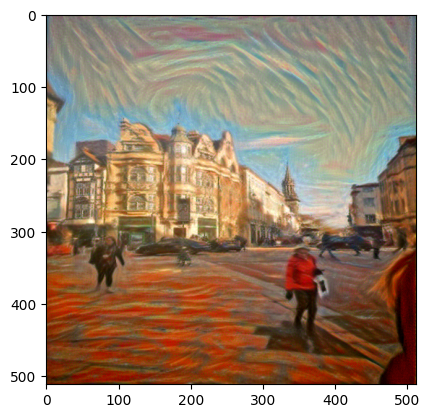

In [13]:
plt.imshow(mpimg.imread('./gen.png'))